In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import random
from pprint import pprint
import copy
from copy import deepcopy

In [2]:
def train_test_split(df, train_size):
    df = df.sample(frac = 1, random_state = 42)
    if type(train_size) == float:
        train_index = int(len(df)*train_size)
    train = df[0:train_index]
    test = df[train_index:]
    return train, test

In [3]:
def give_mean(data):
    tar_col = data[:,-1]
    mean = np.mean(tar_col)
    return mean

In [4]:
def get_potential_splits(data):
    _, num_cols = data.shape
    data = data[:,:num_cols-1]
    _, num_cols = data.shape
    potential_splits = {}
    for i in range(num_cols):
        potential_splits[i] = []
        values = data[:,i]
        values = np.unique(values)

        for j in range(1,len(values)):
            potential_split = (values[j] + values[j-1])/2 
            potential_splits[i].append(potential_split)
    return potential_splits

In [5]:
def split_data(data, split_feature, split_value):
    cond = data[:,split_feature] <= split_value
    data_below = data[cond]
    data_above = data[~cond]
    return data_below, data_above

In [6]:
def cal_rss(data):
    tar_col = data[:,-1]
    rss = np.sum((tar_col - np.mean(tar_col))**2)
    return rss

In [7]:
def calculate_total_rss(data_below, data_above):
    total_rss = cal_rss(data_below)+ cal_rss(data_above)
    return total_rss

In [8]:
def get_best_split(data, potential_splits):
    total_rss = sys.maxsize
    best_split_feature = None
    best_split_value = None
    for i in potential_splits:
        for j in potential_splits[i]:
            data_below, data_above = split_data(data, i, j)
            current_total_rss = calculate_total_rss(data_below, data_above)
            if current_total_rss <= total_rss:
                total_rss = current_total_rss
                best_split_feature = i
                best_split_value = j
                
    return best_split_feature, best_split_value  

In [9]:
def decision_tree_algo(df, max_depth, min_size, counter = 0):
    data = df.values
    if (len(data) < min_size) or (counter == max_depth):
        return give_mean(data)
    else:
        counter += 1
        potential_splits = get_potential_splits(data)
        split_feature, split_value = get_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_feature, split_value)
        
        feature_name = features[split_feature]
        que = "{} <= {}".format(feature_name, split_value)
        sub_tree = {que : []}
        yes_ans = decision_tree_algo(pd.DataFrame(data_below),max_depth, min_size, counter)
        no_ans = decision_tree_algo(pd.DataFrame(data_above), max_depth, min_size, counter)
        if yes_ans == no_ans:
            sub_tree = yes_ans
        else:
            sub_tree[que].append(yes_ans)
            sub_tree[que].append(no_ans)
        return sub_tree

In [11]:
def predict_example(example, tree):
    que = list(tree.keys())[0]
    feature_name, comparison_operator, value = que.split(" ")
    if example[feature_name] <= float(value):
        ans = tree[que][0]
    else: 
        ans = tree[que][1]
        
    if type(ans) != dict:
        return ans
    else:
        residual_tree = ans
        return predict_example(example, residual_tree)

In [12]:
def calculate_r_squared(df, tree):
    values = df.new_cases
    n = len(df)
    mean = values.mean()
    predictions = df.apply(predict_example, args = (tree,), axis = 1)
    ss_res = sum((values - predictions)**2)
    ss_tot = sum((values - mean)**2)
    r_squared = 1 - ss_res / ss_tot
    return r_squared

In [13]:
def create_plot(df, tree, title):
    predictions = df.apply(predict_example, args = (tree,), axis = 1)
    actual = df.new_cases
    plot_df = pd.DataFrame({"actual":actual, "predictions":predictions})
    plot_df.sort_index().plot(figsize = (18, 5), title = title)
    return

In [14]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1-x2))

In [15]:
np.random.seed(42)

class KMeans:
    def __init__(self, K=3, max_iters=100):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        for _ in range(self.max_iters):
            self.clusters = self._create_clusters(self.centroids)
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            if self._is_converged(centroids_old, self.centroids):
                break
        return self._get_cluster_labels(self.clusters)

    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)  
        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [manhattan_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [manhattan_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

if __name__ == "__main__":
    df = pd.read_csv("df.csv")
    df = df.drop(columns = ["Unnamed: 0"])
    df.head()

In [16]:
train, test = train_test_split(df, 0.8)

In [17]:
features = df.columns

In [18]:
data = train.drop(columns = ['new_cases']).values
X = data
k = KMeans(K=3, max_iters=15)
y_pred = k.predict(X)
clusters = k.clusters
cluster_dfs = []
for cluster in clusters:
    temp = copy.deepcopy(df.loc[cluster])
    cluster_dfs.append(temp)

In [19]:
def find_best_fit(df):
    grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": []}
    for max_depth in range(2,11):
        for min_samples in range(2,40,5):
            tree = decision_tree_algo(df, max_depth = max_depth, min_size = min_samples)
            r_squared_train = calculate_r_squared(df, tree)
            grid_search["max_depth"].append(max_depth)
            grid_search["min_samples"].append(min_samples)
            grid_search["r_squared_train"].append(r_squared_train)
    grid_search = pd.DataFrame(grid_search)
    return grid_search.sort_values("r_squared_train", ascending = False).head()

In [20]:
best_fit = []
for i in range(len(cluster_dfs)):
    grid = find_best_fit(cluster_dfs[i])
    best_fit.append(grid)

In [21]:
for i in range(len(best_fit)):
    print(best_fit[i].max_depth.head(1))

64    10
Name: max_depth, dtype: int64
64    10
Name: max_depth, dtype: int64
64    10
Name: max_depth, dtype: int64


In [22]:
for i in range(len(best_fit)):
    print(best_fit[i].min_samples.head(1))

64    2
Name: min_samples, dtype: int64
64    2
Name: min_samples, dtype: int64
64    2
Name: min_samples, dtype: int64


In [23]:
random_forest = []
for i in range(len(cluster_dfs)):
    tree = decision_tree_algo(cluster_dfs[i], 10,2)
    random_forest.append(tree)

In [26]:
predictions = []
for idx in test.index:
    sample = test.loc[idx].values[:-1]
    sample_in_df = test.loc[idx]
    sampleCluster = np.argmin(np.sum((k.centroids - sample)**2, axis = 1))
    tree_instance = random_forest[sampleCluster]
    predictions.append(predict_example(sample_in_df, tree_instance))

predictions = pd.Series(data = predictions, index = test.index)
predictions
values = test.new_cases
mean = values.mean()
x = sum((values - predictions)**2)
y = sum((values - mean)**2)
r_squared = 1 - x / y
print(r_squared)

-0.07113999180537633


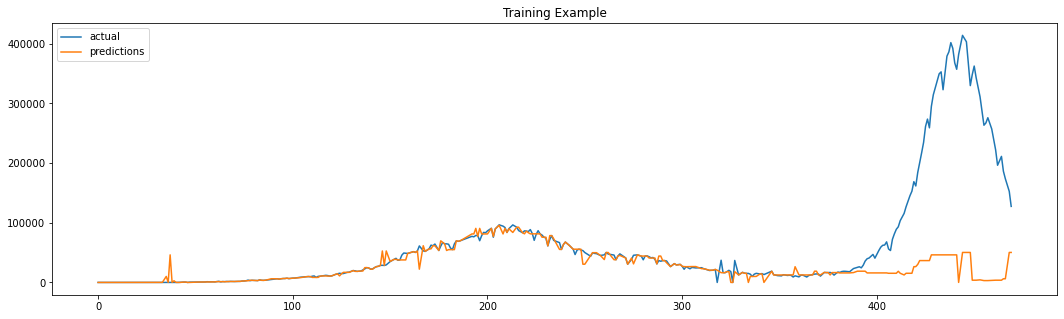

In [27]:
create_plot(train, tree, "Training Example")

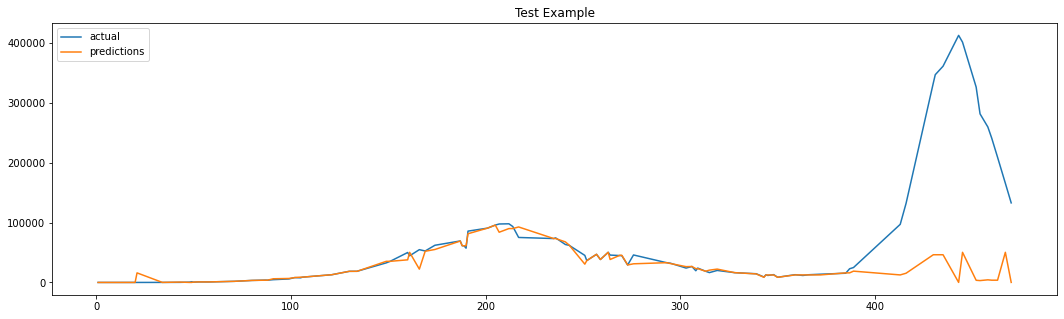

In [28]:
create_plot(test, tree, "Test Example")